# Bias Variance Tradeoff

Now that we have seen errors that can occur if our model is too simplistic, let's see what can occur when we accidentally use a model that is too complicated.

### Setting up our data

We have stored our feature data in the `data.py` file.  Our data adheres to the following model:

$$customer\_amount = 3*temp + 40*is\_weekend + 10 + \epsilon_i$$

Let's load up this data.

In [10]:
from data import temps_and_is_weekends, customers_with_errors

temps_and_is_weekends[0:3]
# [(30, 0), (31, 0), (32, 1)]
customers_with_errors[0:3]
# [125, 133, 170]

[125, 133, 170]

### Building our model

Now let's build our model, and then plot it.

In [21]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(independent_vars, customers_with_errors)

model.coef_
# array([ 3.07299452, 38.61313304])
model.intercept_
# 9.854773197812762
model.score(independent_vars, customers_with_errors)

0.9059072683379463

If we look at the model generated, we see that by training on our data, we get to the following estimated model.

$$ customers = 3.072*temp + 38.613*is\_weekend + 9.854 $$

Here is our plot.

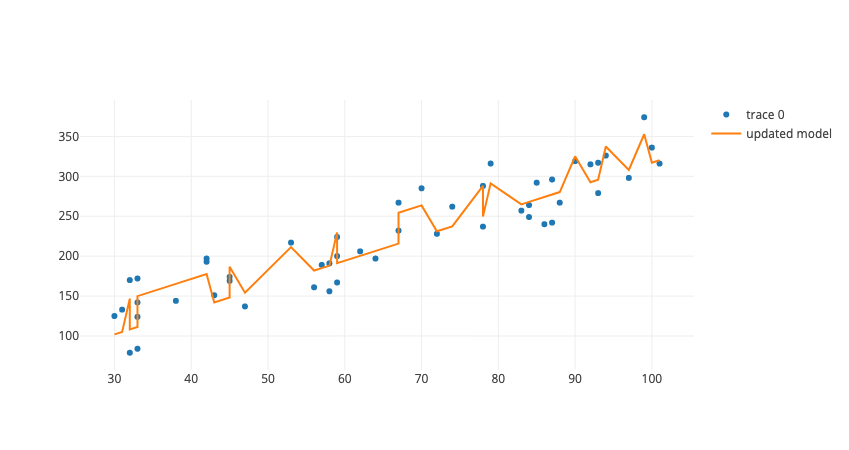

In [20]:
from graph import plot, trace_values, build_layout
import numpy as np
temps = np.array(temps_and_is_weekends)[:, 0]
predictions = model.predict(independent_vars)

trace_1 = dict(x = temps, y =  customers_with_errors, mode = 'markers') 
model_trace = trace_values(temps, predictions, mode = 'lines', name = 'updated model')
plot([trace_1, model_trace])

### We want more

Now our model is pretty good, and has a score of `.905`.  Let's try to do better.  One way that we try to improve our model is by adding another another feature.  But it's difficult to know beforehand if a feature is can be used to explain our outcome.  So we may be adding something to our model that is completely irrelevant.  Let's see what happens when we add an irrelevant feature into our model.

Our irrelevant feature is called `random_ages`, and it represents the average age of the cashiers who were working that day.  But really it's just a list of random data.  Because it's just a list of random data that we'll produce now, it would not have any relevance to our customer amounts list.  Still, let's throw it into our model and see what happens.

In [24]:
from random import randint, seed
seed(2)
random_ages = list(map(lambda num: randint(25,65), range(0, 50)))
random_ages[0:3]

[28, 30, 30]

Ok, let's add it to our list of independent variables and throw it into our model.

In [25]:
updated_independent_vars = list(zip(temps, random_ages, is_weekends))

In [26]:
from sklearn.linear_model import LinearRegression
updated_model = LinearRegression()
updated_model.fit(updated_independent_vars, customers_with_errors)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [33]:
updated_model.score(updated_independent_vars, customers)

0.9661923488240313

Now as you can see, by introducing the `random_ages`, our score did increase.  And by quite a bit - it went from `.905` to `.966`.  And if we look at our graph, things indeed look good.

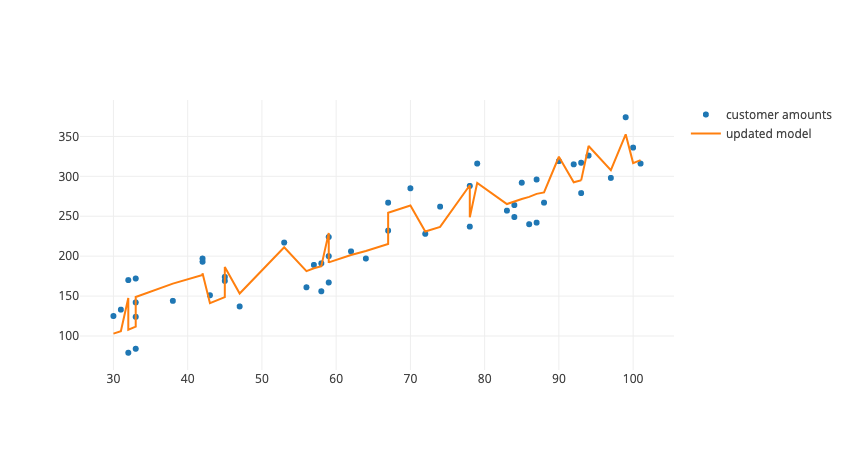

In [28]:
from graph import plot, trace_values, build_layout
updated_predictions = updated_model.predict(updated_independent_vars)
trace_1 = dict(x = temps, y =  customers_with_errors, mode = 'markers', name = 'customer amounts') 
input_temps = list(map(lambda temp: [temp], temps))
updated_model_trace = trace_values(temps, updated_predictions, mode = 'lines', name = 'updated model')
plot([trace_1, updated_model_trace])

And if we look at our updated model, we see a difference from our earlier model of: 

$$ customers = 3.07*temp + -.055*ages + 38.62*is\_weekend + 12.15 $$

In [31]:
updated_model.coef_

array([ 3.07698899, -0.05584566, 38.62306381])

In [32]:
updated_model.intercept_

12.155548281106775

### Why did this work?

So now we have two different models, and the one that includes our random list of average ages has the higher score.  But it seems like it can't be right.  Remember, we just randomly generated our list of ages.  They obviously did not cause an impact on our previously formulated list of customer amounts.  So how do we account for the improvement in our score from .905 to .966?

The reason why training with our list of random numbers improved the model is another case of overfitting.  We are essentially including a noisy, irrelevant parameter in our model.  With this, our linear regression algorithm takes the numbers in this parameter and tries to find an association to the number of customers.  But this association, isn't really there.  It's just picking up on a coincidental association between the random numbers and the average customers.  

This error is called variance.  Variance is an error due to our model picking up on the randomness in the data and not on a real underlying pattern.  As we begin to see, introducing more parameters makes our model more flexible and thus introduces more variance.  

This struggle to balance adding too many parameters and introducing error due to variance, or not including enough parameters and introducing error due to bias is called the bias variance tradeoff.  We'll continue to explore this, as well as a technique to help us strike the right balance - by again using a holdout set.

### Summary 

In this lesson, we saw another source of error called variance.  Error due to variance occurs when our model is too flexible, and we include parameters that do not have predictive value.  Error due to variance can be deceptive because when we introduce variance the score on our training data improves.  However, this is due to our model fitting to randomness in the training data and not detecting an underlying association between our new independent variable and our dependent variable.

We have now seen that error can occur from including too few parameters, which introduces bias, and from too many parameters, which introduces variance.

### But how do we know?

Now the way to detect this overfitting is the same way we did before: we use a holdout set.  This shoudl work, because if the association between say cashier age and customers is real, then it should continue to be predictive even on data the our model did not see.  If it is not a real association, then this means that our model just found a random association that is not likely to be replicated on data it has not seen.

In [99]:
# temps, random_ages, is_weekends
updated_independent_vars[0:3]

[(30, 28, 0), (31, 30, 0), (32, 30, 1)]

Let's holdback twenty datapoint.

In [105]:
training = updated_independent_vars[:30]
holdout = updated_independent_vars[30:]
updated_model_holdout = LinearRegression()

In [106]:
updated_model_holdout.fit(training, customers[:30])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [107]:
updated_model_holdout.score(training, customers[:30])

0.9484549524280912

In [109]:
updated_model_holdout.score(holdout, customers[30:])

0.730206897630308

Ok, so a huge difference here.  It seems like our model was too flexible, which had the model adapt to the randomness in the data, which is unlikely to be reproduced.  Let's try working with a less flexible model.

In [110]:
independent_vars[0:3]

[(30, 0), (31, 0), (32, 1)]

In [112]:
training_orig = independent_vars[:30]
holdout_orig = independent_vars[30:]

In [114]:
original_model_holdout = LinearRegression()
original_model_holdout.fit(training_orig, customers[:30])
original_model_holdout.score(training_orig, customers[:30])

0.9424137369397012

In [115]:
original_model_holdout.score(holdout_orig, customers[30:])

0.7870444181602074

Here we can see that even our score still got significantly worse with the holdout set.  Still, in comparing the two models, leaving out our random customer age improves the model's score on the holdout set, and thus that is the model we would prefer.

Now let's see if our model keeps improving if we keep reducing parameters.  Here, we'll have a parameter of just temperature to predict customers.

In [118]:
input_temps = list(map(lambda temp: [temp] ,temps))

In [119]:
simple_model = LinearRegression()
simple_model.fit(input_temps[:30], customers[:30])
simple_model.score(input_temps[:30], customers[:30])

0.7898820248496575

In [120]:
simple_model.score(input_temps[30:], customers[30:])

0.4704970045149234

Let's make a chart of these score:

| model                  |train score | holdout score |  
| ---------------------- |:----------:| :------------:|
| temps, ages, weekend   | .948        |  .73          |
| temps, weekend         | .942        |  .78 
| temps                  | .78        |  .47 | 

So based on this chart, we would choose the model that has parameters `temps` and `weekend`.

### Summary

In this lesson, we saw how our final source of error, which is variance.  Variance occurs when our model is too flexible, and thus an irrelevant parameter is introduced, which is influenced by the randomness in the data.  Our models are susceptible to variance because increasing more parameters tends to make our models more flexible, which allows for an increased score.  However, adding in these new irrelevant features can affect the numbers of all of our original features as well.  

We can protect against variance with a holdout set, as if our model associating with randomness, we do not expect this to benefit the overfitted model's ability to predict data it has not seen.